In [1]:
!pip install geopandas contextily osmnx==1.1.1 matplotlib==3.3

In [2]:
import osmnx as ox
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import tempfile
import geopandas as gpd
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import contextily as ctx

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
origin_address = "Pyrmont, NSW"

# Load GraphML file

In [4]:
zipurl = 'https://github.com/maxim75/data-visualization/raw/master/notebooks/data/sydney_drive.graphml.zip'

# download ZIP file, unzip it into temp directory and load network from file
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        with tempfile.TemporaryDirectory() as tempdir:
            zfile.extractall(tempdir)
            G = ox.load_graphml(f"{tempdir}/sydney_drive.graphml")

# Configure network

In [5]:
# add travel time based on maximum speed
G = ox.add_edge_speeds(G) 
G = ox.add_edge_travel_times(G) 

# change map projection to Pseudo-Mercator
# this projection is used by most base map tile providers 
G = ox.projection.project_graph(G, to_crs=3857)

# Set origin point

In [6]:
# converts string address into geographocal coordinates
def geocode_address(address, crs=4326):
    geocode = gpd.tools.geocode(address, provider='nominatim', user_agent="drive time demo").to_crs(crs)
    return (geocode.iloc[0].geometry.y, geocode.iloc[0].geometry.x)

# find origin network node
origin_coordinates = geocode_address(origin_address, crs=3857)
origin_node_id = ox.distance.nearest_nodes(G, origin_coordinates[1], origin_coordinates[0])

# Find travel times

In [7]:
# find travel times and route to each node in network
(travel_times, routes) = nx.single_source_dijkstra(G, origin_node_id, weight="travel_time")

# set travel_time in minutes as attribute to each network node
for node_id in travel_times:
    G.nodes.get(node_id)["travel_time"] = travel_times[node_id]/60
    
# get nodes and edges as Geo data frame
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# find longest travel time 
max_time_sec = max(travel_times.values())/60

# Create heatmap

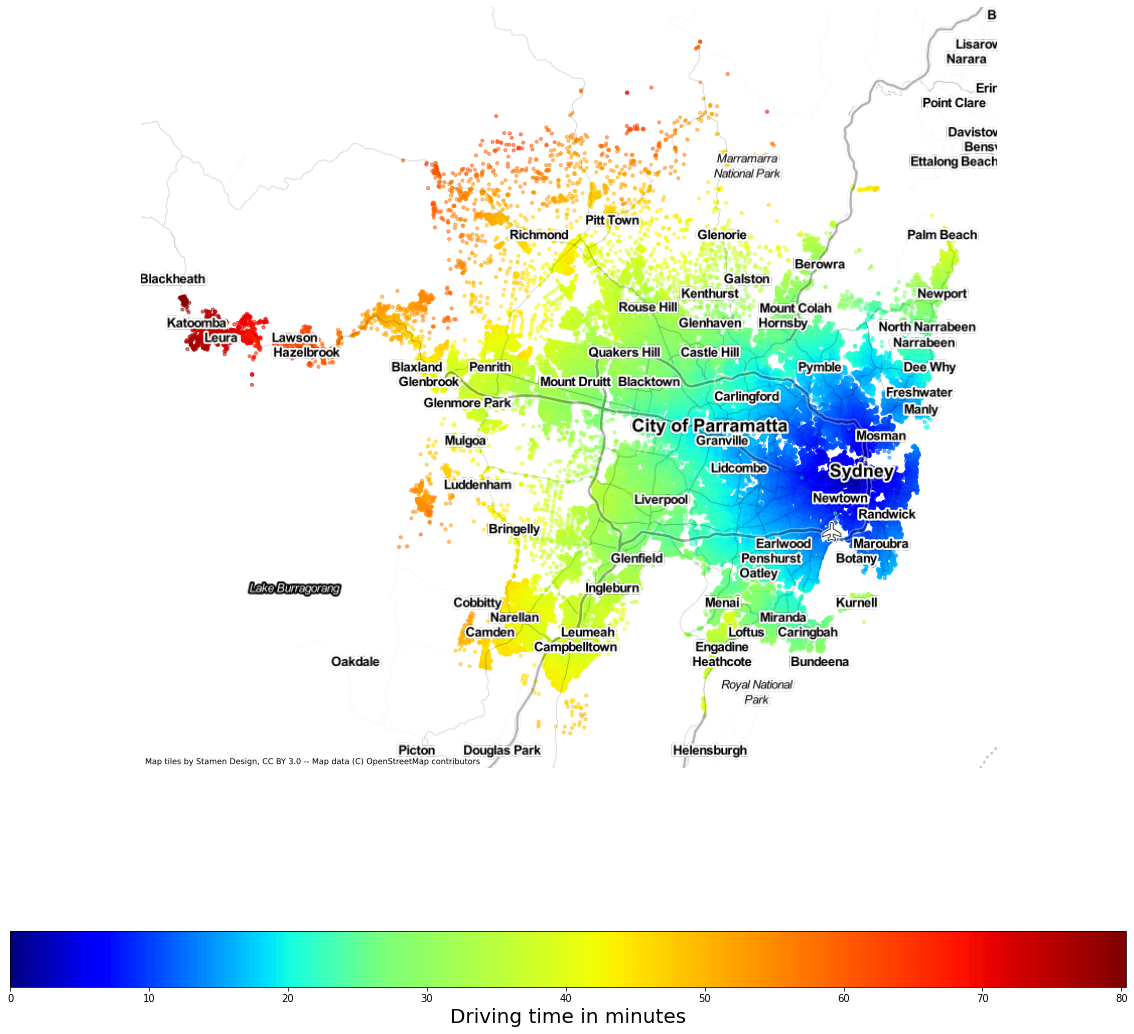

In [8]:
# define color scale using minimum and maximum travel times
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=max_time_sec/3, vmax=max_time_sec)

fig = plt.figure(figsize=(20,20))
ax = plt.axes()

# hide x and y axis
ax.set_axis_off()

# add colotbat showing travel time and corresponding colour
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), 
    ax=ax, orientation='horizontal')

# plot each node with color indicating travel time
gdf_nodes.plot(ax=ax, 
    column="travel_time", cmap="jet", norm=norm, s=10, alpha=.5)

# add basemap with location labels
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLines, alpha=.3)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLabels)

cb.set_label('Driving time in minutes', fontsize = 20)